In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import string 
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from textblob import TextBlob
from tqdm import tqdm
from time import time  
from collections import defaultdict  
import seaborn as sns

import spacy  
import multiprocessing
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec
import logging  
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D


In [ ]:
train = pd.read_csv("/content/train.csv", delimiter=';', header=None, names=['sentence','label'])
test = pd.read_csv("/content/test.csv", delimiter=';', header=None, names=['sentence','label'])
val = pd.read_csv("/content/val.csv", delimiter=';', header=None, names=['sentence','label'])

In [ ]:
train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train.isna().sum()

sentence    0
label       0
dtype: int64

In [ ]:
train.dtypes

sentence    object
label       object
dtype: object

In [ ]:
train.shape, test.shape, val.shape

((16000, 2), (2000, 2), (2000, 2))

# <center>Preprocessing</center> 

## Lowercase

In [ ]:
#changing the text column to lowercase in train df
train["sentence"] = train["sentence"].str.lower()
train.sentence

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: sentence, Length: 16000, dtype: object

In [ ]:
#changing the text column to lowercase in test df
test["sentence"] = test["sentence"].str.lower()
test.sentence

0       im feeling rather rotten so im not very ambiti...
1               im updating my blog because i feel shitty
2       i never make her separate from me because i do...
3       i left with my bouquet of red and yellow tulip...
4         i was feeling a little vain when i did this one
                              ...                        
1995    i just keep feeling like someone is being unki...
1996    im feeling a little cranky negative after this...
1997    i feel that i am useful to my people and that ...
1998    im feeling more comfortable with derby i feel ...
1999    i feel all weird when i have to meet w people ...
Name: sentence, Length: 2000, dtype: object

In [ ]:
#changing the text column to lowercase in val df
val["sentence"] = val["sentence"].str.lower()
val.sentence

0       im feeling quite sad and sorry for myself but ...
1       i feel like i am still looking at a blank canv...
2                          i feel like a faithful servant
3                       i am just feeling cranky and blue
4       i can have for a treat or if i am feeling festive
                              ...                        
1995    im having ssa examination tomorrow in the morn...
1996    i constantly worry about their fight against n...
1997    i feel its important to share this info for th...
1998    i truly feel that if you are passionate enough...
1999    i feel like i just wanna buy any cute make up ...
Name: sentence, Length: 2000, dtype: object

## Punctuation removal 

In [ ]:
#All the charcters in the string lib
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#Takes a text string as input and removes all punctuation marks from it using the translate method and a string of punctuation characters.
def Punc_remove(text):
    punc = string.punctuation + "’‘“”" 
    return text.translate(str.maketrans('', '', punc))

In [ ]:
#This code applies the Punc_remove() function to the 'sentence' column to remove any text punctuations in train df
train['sentence'] = train['sentence'].apply(lambda x: Punc_remove(x))

In [ ]:
#This code applies the Punc_remove() function to the 'sentence' column to remove any text punctuations in test sf
test['sentence'] = test['sentence'].apply(lambda x: Punc_remove(x))

In [ ]:
#This code applies the Punc_remove() function to the 'sentence' column to remove any text punctuations in val sf
val['sentence'] = val['sentence'].apply(lambda x: Punc_remove(x))

In [ ]:
train['sentence']

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: sentence, Length: 16000, dtype: object

## Stopping words removal

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#English stopwords separated by commas using the NLTK 
" , ".join(stopwords.words('english'))

"i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it , it's , its , itself , they , them , their , theirs , themselves , what , which , who , whom , this , that , that'll , these , those , am , is , are , was , were , be , been , being , have , has , had , having , do , does , did , doing , a , an , the , and , but , if , or , because , as , until , while , of , at , by , for , with , about , against , between , into , through , during , before , after , above , below , to , from , up , down , in , out , on , off , over , under , again , further , then , once , here , there , when , where , why , how , all , any , both , each , few , more , most , other , some , such , no , nor , not , only , own , same , so , than , too , very , s , t , can , will , just , don , don't , should , should've , now , d , ll , m , o , re , ve , y , ain , aren ,

In [ ]:
#This function removes the stop words from a given text.
stop_words = set(stopwords.words('english'))
def StopWords_removal(text):
    SW = ' '.join([word for word in text.split() if word not in stop_words])
    return SW

In [ ]:
#This code applies the StopWords_removal() function to the 'sentence' column to remove any text stop words in the train, test and val DFs
train['sentence'] = train['sentence'].apply(lambda x: StopWords_removal(x)) 
test['sentence'] = test['sentence'].apply(lambda x: StopWords_removal(x)) 
val['sentence'] = val['sentence'].apply(lambda x: StopWords_removal(x)) 

In [ ]:
train['sentence']

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996    turning feel pathetic still waiting tables sub...
15997                             feel strong good overall
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: sentence, Length: 16000, dtype: object

## Frequent words 

In [ ]:
#Counts the frequency of each word in the "text" column we didn't remove them as they contain emotions that could help in the classification.
from collections import Counter
cnt = Counter()
def Frequent_words(df_name):
  for text in df_name["sentence"].values:
    for word in text.split():
      cnt[word] += 1
  print(cnt.most_common(10))


In [ ]:
Frequent_words(train)

[('feel', 11183), ('feeling', 5112), ('like', 2908), ('im', 2430), ('really', 942), ('know', 853), ('time', 794), ('get', 740), ('little', 736), ('people', 654)]


In [ ]:
Frequent_words(test)

[('feel', 12577), ('feeling', 5758), ('like', 3281), ('im', 2740), ('really', 1060), ('know', 955), ('time', 894), ('get', 837), ('little', 831), ('people', 750)]


In [ ]:
Frequent_words(val)

[('feel', 13938), ('feeling', 6431), ('like', 3616), ('im', 3055), ('really', 1182), ('know', 1080), ('time', 993), ('little', 932), ('get', 926), ('people', 839)]


## Spelling Correction 

In [ ]:
def correct_sentence_spelling(sentence):
    sentence=str(sentence)
    sentence = TextBlob(sentence)
    result = sentence.correct()
    return result 

In [ ]:
with tqdm(total=len(train)) as pbar:
    for i, row in train.iterrows():
        train.at[i, 'sentence'] = correct_sentence_spelling(row['sentence'])
        pbar.update(1)

train['sentence'] = train['sentence'].apply(lambda x: correct_sentence_spelling(''.join(x)))
train['sentence']

100%|██████████| 16000/16000 [17:30<00:00, 15.23it/s]


0        (d, i, d, n,  , f, e, e, l,  , h, u, m, i, l, ...
1        (g, o,  , f, e, e, l, i, n, g,  , h, o, p, e, ...
2        (i, n,  , g, r, a, f, t, i, n, g,  , m, i, n, ...
3        (e, v, e, r,  , f, e, e, l, i, n, g,  , n, o, ...
4               (f, e, e, l, i, n, g,  , c, r, o, u, c, h)
                               ...                        
15995    (b, r, i, e, f,  , t, i, m, e,  , b, e, a, n, ...
15996    (t, u, r, n, i, n, g,  , f, e, e, l,  , p, a, ...
15997    (f, e, e, l,  , s, t, r, o, n, g,  , g, o, o, ...
15998    (f, e, e, l,  , l, i, k, e,  , r, u, d, e,  , ...
15999    (k, n, o, w,  , l, o, t,  , f, e, e, l,  , s, ...
Name: sentence, Length: 16000, dtype: object

In [ ]:
with tqdm(total=len(test)) as pbar:
    for i, row in test.iterrows():
        test.at[i, 'sentence'] = correct_sentence_spelling(row['sentence'])
        pbar.update(1)

test['sentence'] = test['sentence'].apply(lambda x: correct_sentence_spelling(x))
test['sentence']

100%|██████████| 2000/2000 [02:43<00:00, 12.26it/s]


0       (i, n,  , f, e, e, l, i, n, g,  , r, a, t, h, ...
1       (i, n,  , d, a, t, i, n, g,  , b, l, o, w,  , ...
2       (n, e, v, e, r,  , m, a, k, e,  , s, e, p, a, ...
3       (l, e, f, t,  , b, o, u, q, u, e, t,  , r, e, ...
4       (f, e, e, l, i, n, g,  , l, i, t, t, l, e,  , ...
                              ...                        
1995    (k, e, e, p,  , f, e, e, l, i, n, g,  , l, i, ...
1996    (i, n,  , f, e, e, l, i, n, g,  , l, i, t, t, ...
1997    (f, e, e, l,  , u, s, e, f, u, l,  , p, e, o, ...
1998    (i, n,  , f, e, e, l, i, n, g,  , c, o, m, f, ...
1999    (f, e, e, l,  , w, e, i, r, d,  , m, e, e, t, ...
Name: sentence, Length: 2000, dtype: object

In [ ]:
with tqdm(total=len(val)) as pbar:
    for i, row in val.iterrows():
        val.at[i, 'sentence'] = correct_sentence_spelling(row['sentence'])
        pbar.update(1)

val['sentence'] = val['sentence'].apply(lambda x: correct_sentence_spelling(x))
val['sentence']

100%|██████████| 2000/2000 [02:42<00:00, 12.32it/s]


0       (i, n,  , f, e, e, l, i, n, g,  , q, u, i, t, ...
1       (f, e, e, l,  , l, i, k, e,  , s, t, i, l, l, ...
2       (f, e, e, l,  , l, i, k, e,  , f, a, i, t, h, ...
3       (f, e, e, l, i, n, g,  , c, r, a, n, k, s,  , ...
4       (t, r, e, a, t,  , f, e, e, l, i, n, g,  , f, ...
                              ...                        
1995    (i, n,  , s, e, a,  , e, x, a, m, i, n, a, t, ...
1996    (c, o, n, s, t, a, n, t, l, y,  , w, o, r, r, ...
1997    (f, e, e, l,  , i, m, p, o, r, t, a, n, t,  , ...
1998    (t, r, u, l, y,  , f, e, e, l,  , p, a, s, s, ...
1999    (f, e, e, l,  , l, i, k, e,  , a, n, n, a,  , ...
Name: sentence, Length: 2000, dtype: object

## Tokenization 

In [ ]:
nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tokenize(column):
    tokens = nltk.word_tokenize(str(column)) # Convert to string before tokenizing
    return [w for w in tokens if w.isalpha()] 

In [ ]:
train['sentence'] = train['sentence'].apply(lambda x: tokenize(x))
test['sentence'] = test['sentence'].apply(lambda x: tokenize(x))
val['sentence'] = val['sentence'].apply(lambda x: tokenize(x))

In [ ]:
train['sentence'].head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: sentence, dtype: object

#Label Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['sentence'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train['sentence']), maxlen=256, truncating='pre')
X_test = pad_sequences(tokenizer.texts_to_sequences(test['sentence'].tolist()), maxlen=256, truncating='pre')
X_val = pad_sequences(tokenizer.texts_to_sequences(val['sentence'].tolist()), maxlen=256, truncating='pre')

le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])
y_val = le.transform(val['label'])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Stemming

In [ ]:
stemmer = PorterStemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [ ]:
train['sentence'] = train['sentence'].apply(lambda x: stem_tokens(x))
test['sentence'] = test['sentence'].apply(lambda x: stem_tokens(x))
val['sentence'] = val['sentence'].apply(lambda x: stem_tokens(x))

In [ ]:
train.head()

,sentence,label
0,"[i, didnt, feel, humili]",sadness
1,"[i, can, go, from, feel, so, hopeless, to, so,...",sadness
2,"[im, grab, a, minut, to, post, i, feel, greedi...",anger
3,"[i, am, ever, feel, nostalg, about, the, firep...",love
4,"[i, am, feel, grouchi]",anger


#Training a Pre-trained Word2vec

In [ ]:
import multiprocessing

from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

##Building a vocab table

In [ ]:
t = time()

w2v_model.build_vocab(train['sentence'], progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.0 mins


In [ ]:
t = time()
sentences = sentences = train['sentence']

w2v_model = Word2Vec(sentences, min_count=1, workers=3, window=5)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to train the model: 0.02 mins


In [ ]:
w2v_model.init_sims(replace=True)


<ipython-input-55-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
w2v_model.wv.most_similar('dose')


[('disast', 0.9811000823974609),
 ('favorit', 0.9798094630241394),
 ('tree', 0.9784197807312012),
 ('scene', 0.9780923128128052),
 ('american', 0.977581262588501),
 ('sky', 0.9762808084487915),
 ('male', 0.976127028465271),
 ('member', 0.9759299755096436),
 ('expens', 0.9755527973175049),
 ('middl', 0.9755199551582336)]

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split


max_features = 10000

# Define embedding matrix
vocab_size = len(w2v_model.wv.index_to_key)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in w2v_model.wv.key_to_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

#Building the CNN-LSTM model

In [ ]:
max_features = vocab_size # sets the maximum number of words in vocab
maxlen = X_train.shape[1]
embedding_size = 200 # size of the vector

# Convolution
kernel_size = 5 # sets the size of convolutional window to 5
filters = 128 
pool_size = 4 # sets the size of pooling window to 4

# LSTM
lstm_output_size = 128 # sets the size of output vector of lstm to 128



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D

lstm_output_size = 128
input_dim = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen))# adding an embedding layer to the model
model.add(Dropout(0.25))# dropping 25% of input units to prevent overfitting
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())# taking maximum value for each feature
model.add(Dense(lstm_output_size))#adding dense layer
model.add(Dense(6, activation='softmax', input_dim=input_dim))#addin final layer
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          1048600   
                                                                 
 dropout_1 (Dropout)         (None, 256, 100)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [ ]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# this lets the model terminate if the validation loss is not improved after certain epochs

callback = EarlyStopping(
    monitor="val_loss", # this lets the callback to monitor the validation loss during training
    patience=5, # the model will stop training after waiting for 3 epochs
    restore_best_weights=True, #restoring the weights of the model to the weights with best performance
)

In [ ]:
X_train = X_train.reshape(16000, 256, 1)# reshaping the x_train and X_val so that they match the dimensions of the input fed into the model(3D)
X_val = X_val.reshape(-1, 256, 1)

In [ ]:


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10, 
                    batch_size=156,
                    callbacks=[callback],
                    verbose=1)


Epoch 1/10
103/103 [==============================] - 35s 331ms/step - loss: 0.4172 - accuracy: 0.3281 - val_loss: 0.4163 - val_accuracy: 0.3680
Epoch 2/10
103/103 [==============================] - 34s 329ms/step - loss: 0.3656 - accuracy: 0.4626 - val_loss: 0.2850 - val_accuracy: 0.6025
Epoch 3/10
103/103 [==============================] - 35s 338ms/step - loss: 0.2004 - accuracy: 0.7558 - val_loss: 0.1092 - val_accuracy: 0.8820
Epoch 4/10
103/103 [==============================] - 34s 328ms/step - loss: 0.0792 - accuracy: 0.9144 - val_loss: 0.0743 - val_accuracy: 0.9125
Epoch 5/10
103/103 [==============================] - 34s 329ms/step - loss: 0.0530 - accuracy: 0.9424 - val_loss: 0.0612 - val_accuracy: 0.9270
Epoch 6/10
103/103 [==============================] - 34s 334ms/step - loss: 0.0389 - accuracy: 0.9578 - val_loss: 0.0567 - val_accuracy: 0.9275
Epoch 7/10
103/103 [==============================] - 33s 321ms/step - loss: 0.0308 - accuracy: 0.9674 - val_loss: 0.0593 - val_ac

In [ ]:
model.evaluate(X_test, y_test, verbose=1)


63/63 [==============================] - 1s 16ms/step - loss: 0.0680 - accuracy: 0.9215


[0.06801338493824005, 0.921500027179718]

##Plotting accuracy curve

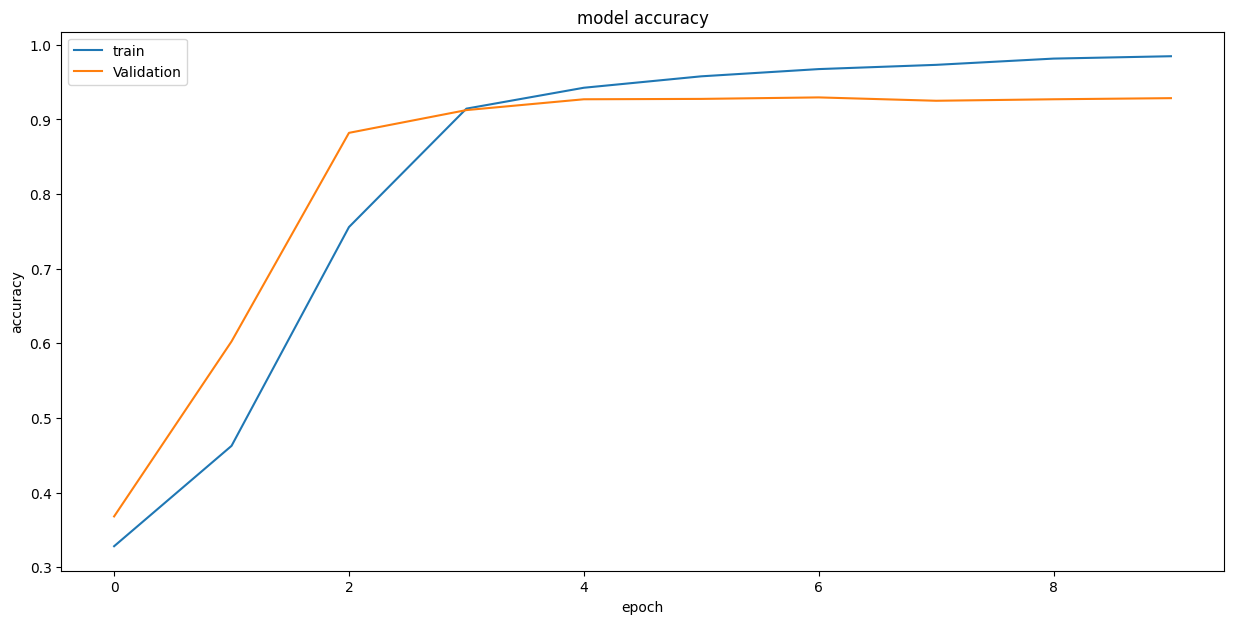

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Plotting loss curve

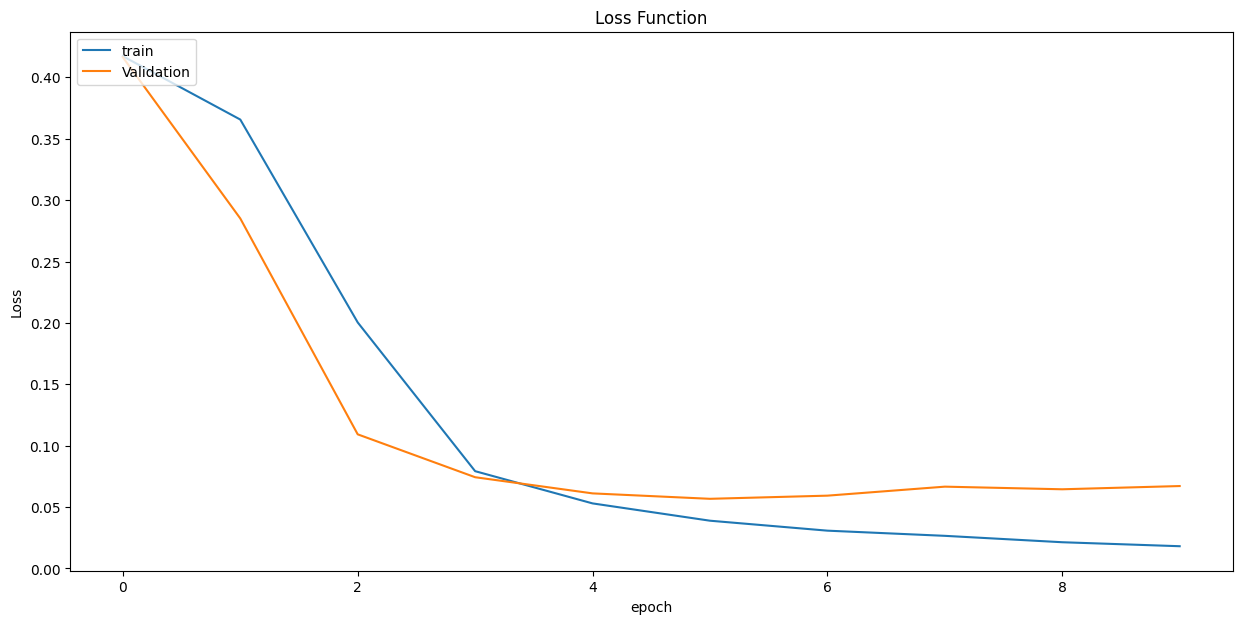

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
X_train.shape

(16000, 256, 1)

In [ ]:
y_train.shape

(16000, 6)

<h2> BERT model

In [ ]:
df = pd.concat([train1,val1,test1],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,sentence,label
0,6325,feel incredibly slacking mrs greedy guts still...,anger
1,1656,im feeling very jaded and uncertain about love...,sadness
2,4543,standing oversized tee shirt baggy yoga pants ...,joy
3,1859,i thought maybe once i started running i would...,joy
4,479,didnt get wink sleep night continued feeling f...,joy


In [ ]:
df.drop('index',axis=1,inplace=True)

In [ ]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=StopWords_removal)
    data[col] = data[col].apply(func=Punc_remove)
    return data

In [ ]:
preprocessed_df = preprocess_data(df,'sentence')
preprocessed_df.head()

,sentence,label
0,feel incredibly slacking mrs greedy guts still...,anger
1,im feeling jaded uncertain love basically im s...,sadness
2,standing oversized tee shirt baggy yoga pants ...,joy
3,thought maybe started running would feel ok,joy
4,didnt get wink sleep night continued feeling f...,joy


In [ ]:
preprocessed_df['num_words'] = preprocessed_df.sentence.apply(len)


In [ ]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

In [ ]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.label)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


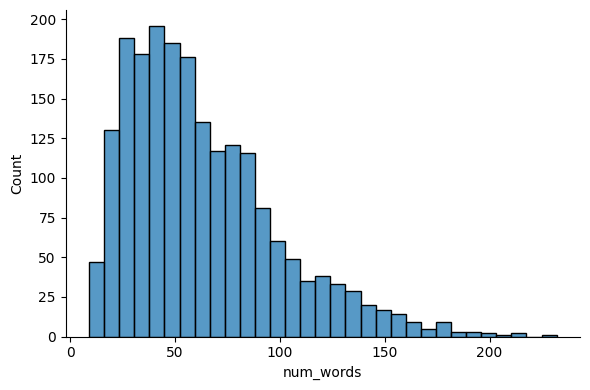

In [ ]:
sns.displot(preprocessed_df.num_words, height=4, aspect=1.5)

In [ ]:
test1 = pd.concat([val,test],axis=0)

In [ ]:
X_train = tokenizer(text=train_data.sentence.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=40,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.sentence.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=40,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

<h3>Defining the model architecture

In [ ]:
input_ids = Input(shape=(40,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(40,),name='attention_mask',dtype=tf.int32)


In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True



In [ ]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer = Adam(learning_rate=5e-5,epsilon=1e-8,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

In [ ]:
train_data['Label'] = train_data.label.map(encoded_labels)
test_data['Label'] = test_data.label.map(encoded_labels)

In [ ]:
train_data.head()


,sentence,label,num_words,Label
571,feeling pretty overwhelmed stressed whole affa...,surprise,192,5
1925,want able leave house without feeling terrifie...,fear,71,1
1435,feel sort pathetic saying iphone internet tv m...,sadness,67,4
969,let emotion leak decision process ended feelin...,anger,57,0
466,feel idiotic letting call us best friends,sadness,41,4


In [ ]:
test_data.head()


,sentence,label,num_words,Label
913,feel liked days tom,love,19,3
631,feel better,joy,11,2
1821,continued feel submissive continued aroused well,sadness,48,4
1399,read one horrific sitting made feel ashamed wo...,sadness,54,4
527,im around husband home alone thinking feel hop...,sadness,51,4


In [ ]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10


44/44 [==============================] - 765s 16s/step - loss: 1.5111 - balanced_accuracy: 0.4271 - val_loss: 1.2413 - val_balanced_accuracy: 0.5517
Epoch 2/10
44/44 [==============================] - 702s 16s/step - loss: 0.9812 - balanced_accuracy: 0.6607 - val_loss: 0.7007 - val_balanced_accuracy: 0.7900
Epoch 3/10
44/44 [==============================] - 709s 16s/step - loss: 0.4817 - balanced_accuracy: 0.8421 - val_loss: 0.4730 - val_balanced_accuracy: 0.8467
Epoch 4/10
44/44 [==============================] - 705s 16s/step - loss: 0.2288 - balanced_accuracy: 0.9379 - val_loss: 0.4338 - val_balanced_accuracy: 0.8700
Epoch 5/10
44/44 [==============================] - 705s 16s/step - loss: 0.1161 - balanced_accuracy: 0.9700 - val_loss: 0.4260 - val_balanced_accuracy: 0.8767
Epoch 6/10
44/44 [==============================] - 703s 16s/step - loss: 0.0749 - balanced_accuracy: 0.9821 - val_loss: 0.4364 - val_balanced_accuracy: 0.8817
Epoch 7/10
44/44 [==============================] -

In [ ]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

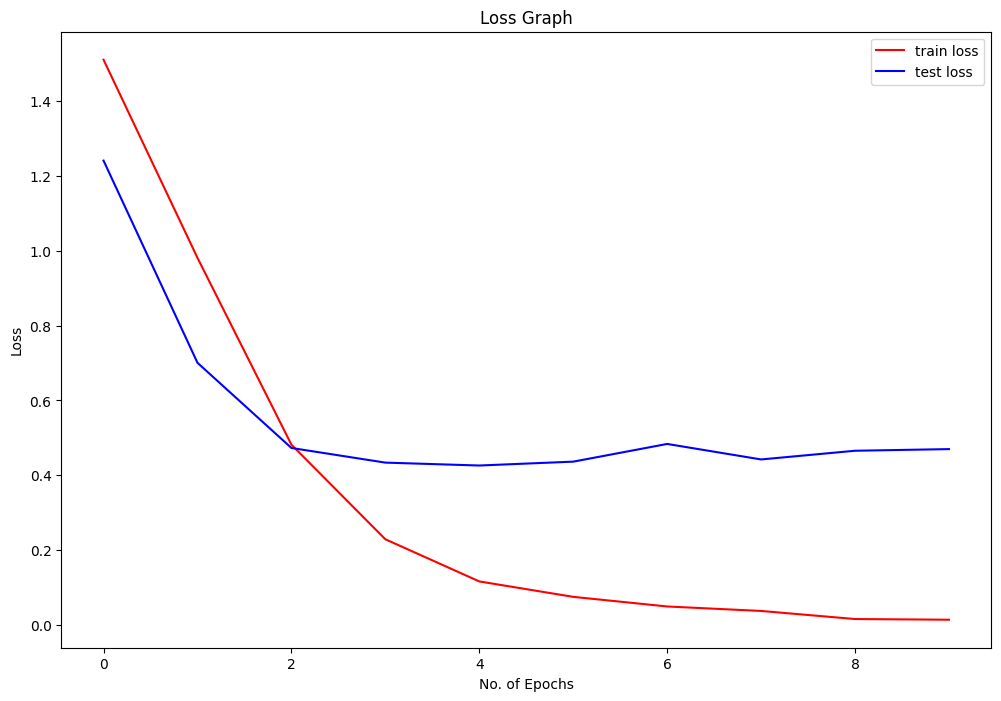

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

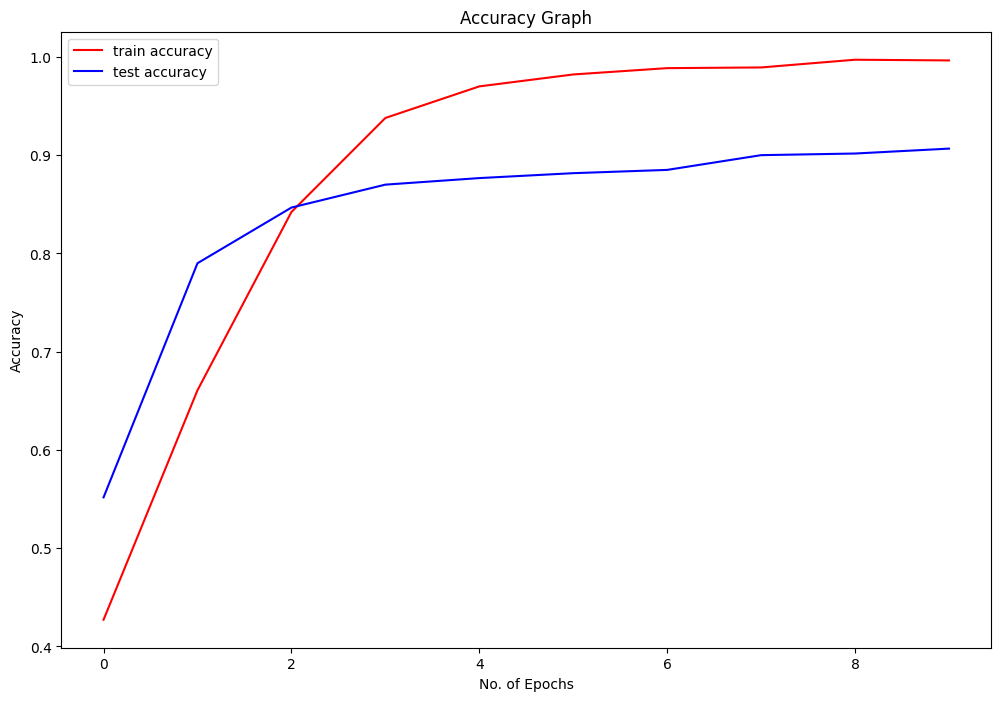

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)


19/19 [==============================] - 99s 5s/step - loss: 0.4699 - balanced_accuracy: 0.9067
Test Categorical Cross-Entropy Loss: 0.4699247181415558
Test Categorical Accuracy: 0.9066666960716248


In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

19/19 [==============================] - 87s 4s/step
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        77
           1       0.89      0.90      0.90        71
           2       0.90      0.95      0.92       211
           3       0.85      0.85      0.85        47
           4       0.93      0.90      0.92       173
           5       0.81      0.81      0.81        21

    accuracy                           0.91       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.91      0.91      0.91       600



<h1>Comparison

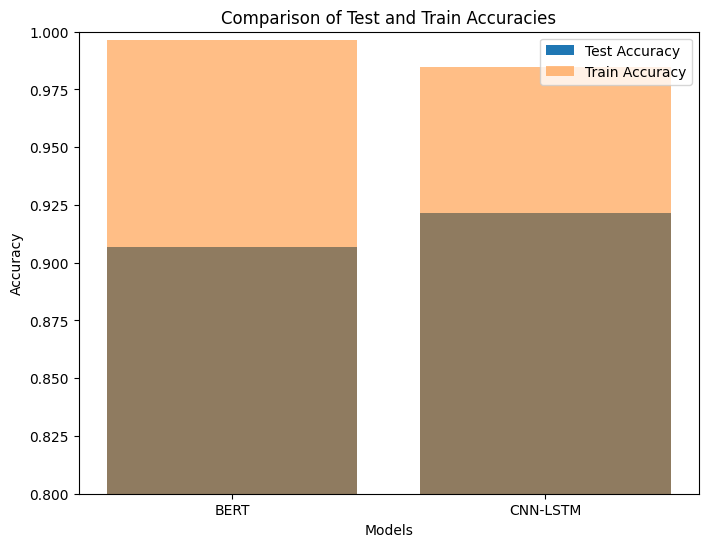

In [ ]:
import matplotlib.pyplot as plt

# Define the data
test_accuracies = [0.9066666960716248, 0.9215]
train_accuracies = [0.9964, 0.9847]
models = ['BERT', 'CNN-LSTM']

# Set the figure size
plt.figure(figsize=(8, 6))

# Create a combined bar chart for test and train accuracies
plt.bar(models, test_accuracies, label='Test Accuracy')
plt.bar(models, train_accuracies, label='Train Accuracy', alpha=0.5)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Test and Train Accuracies')
plt.ylim(0.8, 1.0)  # Set the y-axis limits
plt.legend()  # Add legend
plt.show()
